In [1]:
import pandas as pd
from dotenv import load_dotenv
from pathlib import Path
import os

In [2]:
# load environment variables from .env file for project
dotenv_path = Path('../.env')
load_dotenv(dotenv_path=dotenv_path)

True

We converted the `comma-separated values files` (CSV) in a earlier stage to `Apache parquet` files. Parquet files make processing with `pandas` faster and more memory efficient. The processed parquet files are the `OUTPUT_DIRECTORY` given in the `.env` file of the project.

In [3]:
data_directory = os.getenv("OUTPUT_DIRECTORY")

List all files in the `OUTPUT_DIRECTORY`.

In [4]:
os.listdir(data_directory)

['ssi_omzet_eans_coicops_plus_202107_202308.parquet',
 'OmzetEansCoicopsPlus_202206_202308.parquet',
 'converted_csvs',
 'ssi_omzet_eans_coicops_lidl_2018_202308.parquet',
 'OmzetEansCoicopsLidl_202007_202202.parquet',
 'OutputEansCoicopsPlus_202107_202205.parquet',
 'OmzetEansCoicopsPlus_202107_202205.parquet',
 'OmzetEansCoicopsLidl_202203_202308.parquet',
 'KassabonPlus_va_202201.parquet',
 'OmzetEansCoicopsLidl_2018_202006.parquet']

# Analysis of the LIDL data

Let's focus on the LIDL file first.

In [5]:
lidl_revenue_files = [os.path.join(data_directory, filename) for filename in os.listdir(data_directory) if filename.startswith("Omzet") and "Lidl" in filename]
lidl_revenue_files

['/data/projecten/ssi/data/OmzetEansCoicopsLidl_202007_202202.parquet',
 '/data/projecten/ssi/data/OmzetEansCoicopsLidl_202203_202308.parquet',
 '/data/projecten/ssi/data/OmzetEansCoicopsLidl_2018_202006.parquet']

In [6]:
for revenue_file in lidl_revenue_files:
    print(list(pd.read_parquet(revenue_file, engine="pyarrow").columns))

['bg_number', 'month', 'coicop_number', 'coicop_name', 'isba_number', 'isba_name', 'esba_number', 'esba_name', 'rep_id', 'ean_number', 'ean_name', 'revenue', 'amount']
['bg_number', 'month', 'coicop_number', 'coicop_name', 'isba_number', 'isba_name', 'esba_number', 'esba_name', 'rep_id', 'ean_number', 'ean_name', 'revenue', 'amount']
['bg_number', 'month', 'coicop_number', 'coicop_name', 'isba_number', 'isba_name', 'esba_number', 'esba_name', 'rep_id', 'ean_number', 'ean_name', 'revenue', 'amount']


In [7]:
lidl_df = pd.concat([pd.read_parquet(revenue_file, engine="pyarrow") for revenue_file in lidl_revenue_files])
lidl_df = lidl_df.sort_values(by=["bg_number","month", "coicop_number"], ascending=[True, True, True]).reset_index(drop=True)
lidl_df.to_parquet(os.path.join(data_directory, "ssi_omzet_eans_coicops_lidl_2018_202308.parquet"), engine="pyarrow")

In [8]:
lidl_df = pd.read_parquet(os.path.join(data_directory, 'ssi_omzet_eans_coicops_lidl_2018_202308.parquet'), engine="pyarrow")
lidl_df.head()

,bg_number,month,coicop_number,coicop_name,isba_number,isba_name,esba_number,esba_name,rep_id,ean_number,ean_name,revenue,amount
0,908515,201801,11110,Rijst,11110901,Rijst,47_40,Grund-/Nähr-/Hilfsmittel/Frühstück_Reis,3185518,92775.0,Sushi rijst,0.990000,1.0
1,908515,201801,11110,Rijst,11110901,Rijst,47_40,Grund-/Nähr-/Hilfsmittel/Frühstück_Reis,3183385,22571.0,Italiaanse Risotto gesorteerd,4150.209961,2565.0
2,908515,201801,11110,Rijst,11110901,Rijst,47_40,Grund-/Nähr-/Hilfsmittel/Frühstück_Reis,3183851,51009.0,Rijst zilvervlies 1kg,169094.890625,121651.0
3,908515,201801,11110,Rijst,11110901,Rijst,47_40,Grund-/Nähr-/Hilfsmittel/Frühstück_Reis,3183852,51010.0,Rijst wit 1kg,78635.203125,66080.0
4,908515,201801,11110,Rijst,11110901,Rijst,47_40,Grund-/Nähr-/Hilfsmittel/Frühstück_Reis,3183945,55571.0,Traditionele basmati rijst XXL,473773.781250,67783.0


As per their definition COICOP definitions should be 5 digits long: 
- Two digits for the COICOP division, ranging from 01 until
- One digit for the COICOP group
- One digit for the COICOP class
- One digit for the COICOP subclass
See for more information the PDF [here](https://unstats.un.org/unsd/classifications/unsdclassifications/COICOP_2018_-_pre-edited_white_cover_version_-_2018-12-26.pdf). 
Check if this is the case for the coicop numbers in the LIDL dataframe.

In [9]:
lidl_df.coicop_number.str.len().value_counts().reset_index()

,coicop_number,count
0,5,314757
1,6,98523
2,1,1367


It seems there are COICOP numbers with 5 digits, 6 digits, and even 1 digits. Let's check the COICOP numbers with one digit first:

In [10]:
lidl_df[lidl_df.coicop_number.str.len() == 1].head(10)

,bg_number,month,coicop_number,coicop_name,isba_number,isba_name,esba_number,esba_name,rep_id,ean_number,ean_name,revenue,amount
112420,908515,202001,0,Onbekend,0,Onbekend,121_100,Sport Hartwaren_Fahrrad,17927206,327185.0,Fietsbel ping,17.900000,18.0
112421,908515,202001,0,Onbekend,0,Onbekend,121_100,Sport Hartwaren_Fahrrad,17927207,327187.0,Fietswielverlichting LED,73.010002,15.0
112422,908515,202001,0,Onbekend,0,Onbekend,121_100,Sport Hartwaren_Fahrrad,17927208,327218.0,Zadelhoes,69.000000,69.0
112423,908515,202001,0,Onbekend,0,Onbekend,121_100,Sport Hartwaren_Fahrrad,17927209,344101.0,Fietskrat wit,26.969999,3.0
112424,908515,202001,0,Onbekend,0,Onbekend,121_100,Sport Hartwaren_Fahrrad,3193227,8005.0,Elektrische push-bel,2.000000,1.0
112425,908515,202001,0,Onbekend,0,Onbekend,121_100,Sport Hartwaren_Fahrrad,3193231,8009.0,Spiraalslot,10.000000,2.0
112426,908515,202001,0,Onbekend,0,Onbekend,121_100,Sport Hartwaren_Fahrrad,3193232,8010.0,Kettingslot,120.000000,24.0
112427,908515,202001,0,Onbekend,0,Onbekend,121_100,Sport Hartwaren_Fahrrad,3193233,8017.0,Fietstas 35 L,14.990000,1.0
112428,908515,202001,0,Onbekend,0,Onbekend,121_100,Sport Hartwaren_Fahrrad,3193235,8029.0,Bagagedragerkussen,43.889999,11.0
112429,908515,202001,0,Onbekend,0,Onbekend,121_100,Sport Hartwaren_Fahrrad,3193239,8035.0,Fietszadel design,5.000000,1.0


The COICOP number for COICOP numbers of length 1 has value 0 for the first 10 rows. See which other values are possible:

In [11]:
lidl_df[lidl_df.coicop_number.str.len() == 1].coicop_number.value_counts()

coicop_number
0    1367
Name: count, dtype: int64

It seems all COICOP numbers with lenght 1 have value 0. This seems a special value? Let's check the COICOP values with 6 digits:

In [12]:
lidl_df[lidl_df.coicop_number.str.len() == 6].head(10)

,bg_number,month,coicop_number,coicop_name,isba_number,isba_name,esba_number,esba_name,rep_id,ean_number,ean_name,revenue,amount
1950,908515,201801,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320901,Artikelen voor persoonlijke hygiëne en wellnes...,82_10,Kosmetik_Haarpflege,3180115,118451.0,Professionele haarolie serum,11.970000,3.0
1951,908515,201801,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320901,Artikelen voor persoonlijke hygiëne en wellnes...,82_10,Kosmetik_Haarpflege,3180116,118452.0,Professionele haarzorg BB Balm,7.980000,2.0
1952,908515,201801,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320901,Artikelen voor persoonlijke hygiëne en wellnes...,82_10,Kosmetik_Haarpflege,3184901,99335.0,Med shampoo,7846.339844,5266.0
1953,908515,201801,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320901,Artikelen voor persoonlijke hygiëne en wellnes...,82_20,"Kosmetik_Duschgel, Bäder, Seifen",3180054,105741.0,Showercream gesorteerd,57.669998,118.0
1954,908515,201801,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320901,Artikelen voor persoonlijke hygiëne en wellnes...,82_20,"Kosmetik_Duschgel, Bäder, Seifen",3180060,106537.0,Antibacteriële handzeep,19400.039062,19596.0
1955,908515,201801,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320901,Artikelen voor persoonlijke hygiëne en wellnes...,82_20,"Kosmetik_Duschgel, Bäder, Seifen",3180124,119480.0,Knijpzeep Cars,505.660004,359.0
1956,908515,201801,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320901,Artikelen voor persoonlijke hygiëne en wellnes...,82_20,"Kosmetik_Duschgel, Bäder, Seifen",3182929,123510.0,Frozen bad kleurtablet gesorteerd,966.000000,330.0
1957,908515,201801,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320901,Artikelen voor persoonlijke hygiëne en wellnes...,82_20,"Kosmetik_Duschgel, Bäder, Seifen",3180167,126110.0,Douchegel tropical summer,197.639999,206.0
1958,908515,201801,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320901,Artikelen voor persoonlijke hygiëne en wellnes...,82_20,"Kosmetik_Duschgel, Bäder, Seifen",3180173,128291.0,Douchecreme tradition gesorteerd,344.670013,363.0
1959,908515,201801,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320901,Artikelen voor persoonlijke hygiëne en wellnes...,82_20,"Kosmetik_Duschgel, Bäder, Seifen",3180174,128293.0,Douchegel tradition gesorteerd,287.250000,305.0


Check what are the possible values for COICOPs with 6 digits:

In [13]:
lidl_df[lidl_df.coicop_number.str.len() == 6].coicop_number.value_counts()

coicop_number
999999    82275
121320    14002
121210     1553
121310      693
Name: count, dtype: int64

It looks like there are only four different values for COICOP numbers with 6 digits:
- 999999
- 121320     
- 121210      
- 121310       

`999999` seems a special value, maybe missing values or an additional category? The other values are not that clear. Check the COICOP numbers with lenght 5.

In [14]:
lidl_df[lidl_df.coicop_number.str.len() == 5].coicop_number.value_counts()

coicop_number
11140    20824
21210    17409
31220    14647
11450    13903
11270    13091
         ...  
12130      160
11930      133
95220       80
11220       50
95300        9
Name: count, Length: 78, dtype: int64

It seems there are 78 unique COICOP values with length 5. Check is this is indeed the case:

In [15]:
lidl_df[lidl_df.coicop_number.str.len() == 5].coicop_number.nunique()

78

This seems correct. Because we 5 and 6 digit COICOP numbers, it might be the case that the CBS classifies the COICOP one level deeper than the specification. The COICOP specification specifies the COICOP division using two digits. The first categories in the COICOP classification 1-9 are defined using a leading zero. See if we can find any leading zeroes in the COICOP numbers defined by LIDL.

In [16]:
lidl_df[lidl_df.coicop_number.str.len() == 5].coicop_number.str.startswith("0").sum()

0

This does not seem to be the case. It looks like the coicop numbers in the LIDL file are missing the leading zero. This means that the 6 digit labels we found about are part of COICOP division `12`, "Insurance and financial services". This is a bit strange because above the product descriptions appear to be all "articles for personal hygiene" which are defined to be in COICOP division `13.1`.

In [17]:
lidl_df[(lidl_df.coicop_number.str.len() == 6) & (lidl_df.coicop_number.str.startswith("12"))].head(10)

,bg_number,month,coicop_number,coicop_name,isba_number,isba_name,esba_number,esba_name,rep_id,ean_number,ean_name,revenue,amount
1950,908515,201801,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320901,Artikelen voor persoonlijke hygiëne en wellnes...,82_10,Kosmetik_Haarpflege,3180115,118451.0,Professionele haarolie serum,11.970000,3.0
1951,908515,201801,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320901,Artikelen voor persoonlijke hygiëne en wellnes...,82_10,Kosmetik_Haarpflege,3180116,118452.0,Professionele haarzorg BB Balm,7.980000,2.0
1952,908515,201801,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320901,Artikelen voor persoonlijke hygiëne en wellnes...,82_10,Kosmetik_Haarpflege,3184901,99335.0,Med shampoo,7846.339844,5266.0
1953,908515,201801,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320901,Artikelen voor persoonlijke hygiëne en wellnes...,82_20,"Kosmetik_Duschgel, Bäder, Seifen",3180054,105741.0,Showercream gesorteerd,57.669998,118.0
1954,908515,201801,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320901,Artikelen voor persoonlijke hygiëne en wellnes...,82_20,"Kosmetik_Duschgel, Bäder, Seifen",3180060,106537.0,Antibacteriële handzeep,19400.039062,19596.0
1955,908515,201801,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320901,Artikelen voor persoonlijke hygiëne en wellnes...,82_20,"Kosmetik_Duschgel, Bäder, Seifen",3180124,119480.0,Knijpzeep Cars,505.660004,359.0
1956,908515,201801,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320901,Artikelen voor persoonlijke hygiëne en wellnes...,82_20,"Kosmetik_Duschgel, Bäder, Seifen",3182929,123510.0,Frozen bad kleurtablet gesorteerd,966.000000,330.0
1957,908515,201801,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320901,Artikelen voor persoonlijke hygiëne en wellnes...,82_20,"Kosmetik_Duschgel, Bäder, Seifen",3180167,126110.0,Douchegel tropical summer,197.639999,206.0
1958,908515,201801,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320901,Artikelen voor persoonlijke hygiëne en wellnes...,82_20,"Kosmetik_Duschgel, Bäder, Seifen",3180173,128291.0,Douchecreme tradition gesorteerd,344.670013,363.0
1959,908515,201801,121320,Artikelen voor persoonlijke hygiëne en wellne...,121320901,Artikelen voor persoonlijke hygiëne en wellnes...,82_20,"Kosmetik_Duschgel, Bäder, Seifen",3180174,128293.0,Douchegel tradition gesorteerd,287.250000,305.0


Let's assume for now that the labeling is correct, and add the trailing zero to COICOP numbers with length 5.

In [18]:
lidl_df.loc[lidl_df.coicop_number.str.len() == 5, 'coicop_number'] = lidl_df[lidl_df.coicop_number.str.len() == 5].coicop_number.apply(lambda s: f"0{s}")

Check if all COICOP numbers with length 5 are removed:

In [19]:
lidl_df.coicop_number.str.len().value_counts().reset_index()

,coicop_number,count
0,6,413280
1,1,1367


Derive the COICOP division (the first two digits in the COICOP number) and assign them to a new column.

In [20]:
lidl_df['coicop_division'] = lidl_df[lidl_df.coicop_number.str.len() == 6].coicop_number.str[:2]
lidl_df.head()

,bg_number,month,coicop_number,coicop_name,isba_number,isba_name,esba_number,esba_name,rep_id,ean_number,ean_name,revenue,amount,coicop_division
0,908515,201801,011110,Rijst,11110901,Rijst,47_40,Grund-/Nähr-/Hilfsmittel/Frühstück_Reis,3185518,92775.0,Sushi rijst,0.990000,1.0,01
1,908515,201801,011110,Rijst,11110901,Rijst,47_40,Grund-/Nähr-/Hilfsmittel/Frühstück_Reis,3183385,22571.0,Italiaanse Risotto gesorteerd,4150.209961,2565.0,01
2,908515,201801,011110,Rijst,11110901,Rijst,47_40,Grund-/Nähr-/Hilfsmittel/Frühstück_Reis,3183851,51009.0,Rijst zilvervlies 1kg,169094.890625,121651.0,01
3,908515,201801,011110,Rijst,11110901,Rijst,47_40,Grund-/Nähr-/Hilfsmittel/Frühstück_Reis,3183852,51010.0,Rijst wit 1kg,78635.203125,66080.0,01
4,908515,201801,011110,Rijst,11110901,Rijst,47_40,Grund-/Nähr-/Hilfsmittel/Frühstück_Reis,3183945,55571.0,Traditionele basmati rijst XXL,473773.781250,67783.0,01


When we have the COICOP division, we can count the number of products in each division.

In [21]:
lidl_df.coicop_division.value_counts()

coicop_division
01    196848
99     82275
05     38049
03     34092
02     24461
09     19533
12     16248
06      1774
Name: count, dtype: int64

We can also plot this in a barplot:

<Axes: xlabel='coicop_division'>

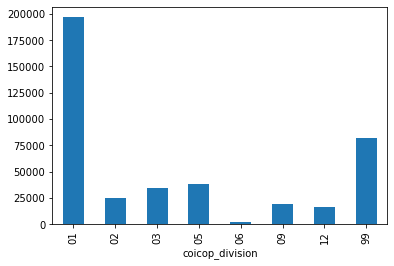

In [22]:
lidl_df.coicop_division.value_counts().sort_index().plot(kind="bar")

According to this barchart the following COICOP divisions are present in the LIDL dataset:
- 01 Food and non-alcoholic beverages
- 02 Alcoholic beverages, tobacco and narcotics
- 03 Clothing and footwear
- 05 Furnishings, household equipment and routine household maintenance
- 06 Health
- 09 Recreation, sport and culture
- 12 Insurance and financial services
- 99 Does not exist in COICOP divisions, this is probably some CBS specific category?

As we have seen earlier, the division 12 present in the list here, is probably mixed up with COICOP division 13 "Personal care, social protection and miscellaneous goods and services". The LIDL data also contains a column with COICOP descriptions. Let's see which divisions have which descriptions:

In [23]:
coicop_division_descriptions = lidl_df.groupby(by="coicop_division")["coicop_name"].value_counts().reset_index()
coicop_division_descriptions

,coicop_division,coicop_name,count
0,01,Overige bakkerijproducten,20824
1,01,Kaas en kwark,13903
2,01,"Gedroogd, gezouten of gerookt vlees",13091
3,01,Verse of gekoelde groenten behalve aardappele...,11514
4,01,"Gedroogde groenten, andere bereidingen en con...",11436
...,...,...,...
78,12,Artikelen voor persoonlijke hygiëne en wellne...,14002
79,12,Elektrische apparaten voor lichaamsverzorging,1553
80,12,Niet-elektrische apparaten,693
81,99,Onbekend,73108


In [24]:
coicop_division_descriptions[coicop_division_descriptions.coicop_division == "01"]

,coicop_division,coicop_name,count
0,01,Overige bakkerijproducten,20824
1,01,Kaas en kwark,13903
2,01,"Gedroogd, gezouten of gerookt vlees",13091
3,01,Verse of gekoelde groenten behalve aardappele...,11514
4,01,"Gedroogde groenten, andere bereidingen en con...",11436
5,01,Kant-en-klaarmaaltijden,9598
6,01,Chocolade,8966
7,01,Snoepgoed,8885
8,01,Frisdranken,8685
9,01,Gedroogd fruit en noten,7710


The COICOP descriptions for COICOP division 01 seem to be all related to "Food and non-alcoholic beverages".

In [25]:
coicop_division_descriptions[coicop_division_descriptions.coicop_division == "02"]

,coicop_division,coicop_name,count
45,02,Wijn van druiven,17409
46,02,Pils,6076
47,02,Distillatiewijn,742
48,02,Gedistilleerde dranken en likeuren,234


The products for COICOP division 02 are all "Alcoholic beverages, tobacco and narcotics"

In [26]:
coicop_division_descriptions[coicop_division_descriptions.coicop_division == "03"]

,coicop_division,coicop_name,count
49,03,Dameskleding,14647
50,03,Herenkleding,11152
51,03,Baby- en kinderkleding,3791
52,03,Damesschoenen,1867
53,03,Herenschoenen,1443
54,03,Overige kledingartikelen,732
55,03,Kinderschoenen,460


Also the products for COICOP division 03 are all "Clothing and footwear".

In [27]:
coicop_division_descriptions[coicop_division_descriptions.coicop_division == "05"]

,coicop_division,coicop_name,count
56,05,Schoonmaak- en onderhoudsproducten,8612
57,05,Overige niet-duurzame kleine huishoudproducte...,7311
58,05,Niet-elektrische keukenartikelen,4486
59,05,Diverse losse onderdelen,4141
60,05,Grote gereedschappen en werktuigen met motor,3873
61,05,Beddengoed,3416
62,05,"Koffiezetapparaten, waterkokers en dergelijke",3028
63,05,Tafel- en toiletlinnen,1159
64,05,"Glaswerk, kristal en aardewerk of porselein",849
65,05,Kleine handgereedschappen,691


The products in COICOP division 05 are indeed all related to "Furnishings, household equipment and routine household maintenance". More specifically, they seem related to COICOP groups:
- 05.2 Household textiles
- 05.3 Household appliances
- 05.4 Glassware, tableware and household utensils
- 05.5 Tools and equipment for house and garden

We have to check the futher division in COICOP groups later.

In [28]:
coicop_division_descriptions[coicop_division_descriptions.coicop_division == "06"]

,coicop_division,coicop_name,count
67,06,Overige medische producten n.e.g.,909
68,06,Farmaceutische producten,865


The products in COICOP division 06 seems to be all related to "Health".

In [29]:
coicop_division_descriptions[coicop_division_descriptions.coicop_division == "09"]

,coicop_division,coicop_name,count
69,09,Speelgoed en feestartikelen,9983
70,09,Producten voor huisdieren,4501
71,09,Planten en bloemen,2704
72,09,Overige schrijfwaren en tekenartikelen,857
73,09,Fictieboeken,633
74,09,Spellen en hobby’s,458
75,09,Producten van papier,308
76,09,Tijdschriften,80
77,09,Divers drukwerk,9


The products in COICOP division 09 look all related to the broader COICOP description "Recreation, sport and culture". Especially, the products here look part of the following COICOP groups:
- 09.1 Recreational durables
- 09.2 Other recreational goods
- 09.3 Garden products and pets
- 09.7 Newspapers, books and stationery

In [30]:
coicop_division_descriptions[coicop_division_descriptions.coicop_division == "12"]

,coicop_division,coicop_name,count
78,12,Artikelen voor persoonlijke hygiëne en wellne...,14002
79,12,Elektrische apparaten voor lichaamsverzorging,1553
80,12,Niet-elektrische apparaten,693


The products in COICOP division 12 should be related to "Insurance and financial services". However, it looks like all the products and their descriptions here are instead "Personal care, social protection and miscellaneous goods and services". Thus, we think these products instead should have COICOP_division 13 instead. In addition, there is an extra category "Non-electrical devices" which may fall under "miscellaneous goods".

In [31]:
coicop_division_descriptions[coicop_division_descriptions.coicop_division == "99"]

,coicop_division,coicop_name,count
81,99,Onbekend,73108
82,99,Divers,9167


The last category with COICOP division "99" seems to be an "unknown" or "divers" category. This looks like an NSI specific category not available in the COICOP specification. In general, we see that all but one category follow the COICOP specification. We will have to look into what went wrong with COICOP division "12". 

In conclusion, we see that the CBS has an extra COICOP level because most category should have 6 digits. The 5 digit codes in the LIDL file contain COICOP numbers under 10 without the zero prefix. By adding this prefix back we standardized most COICOP numbers and could derive COICOP division numbers. These seem to be overall correct. There's still a collection of rows that have COICOP number 0. Let's analyze the product descriptions for the products with COICOP number 0.

In [32]:
lidl_df[lidl_df.coicop_number == "0"].coicop_name.value_counts().reset_index()

,coicop_name,count
0,Onbekend,1367


Apparently, products with COICOP number 0 are another "unknown" category. We do not know how these products are related to the other category of "unknown" products with "COICOP division" 99.

In [43]:
import plotly.express as px

#fig = px.scatter(coicop_division_descriptions, x="coicop_division", y="count")
#fig.write_image("scatter.png", engine="orca")

In [56]:
def split_coicop(coicop_column: pd.Series) -> pd.DataFrame:
    return pd.DataFrame({"coicop_number": coicop_column, 
        "coicop_division": coicop_column.str[:2],
        "coicop_group": coicop_column.str[2:3],
        "coicop_class": coicop_column.str[3:4],
        "coicop_subclass": coicop_column.str[4:5],
        "coicop_subsubclass": coicop_column.str[5:],
    })

unique_coicop = pd.Series(lidl_df[lidl_df.coicop_number.str.len() == 6].coicop_number.unique())
split_coicop(unique_coicop)

,coicop_number,coicop_division,coicop_group,coicop_class,coicop_subclass,coicop_subsubclass
0,011110,01,1,1,1,0
1,011130,01,1,1,3,0
2,011140,01,1,1,4,0
3,011160,01,1,1,6,0
4,011170,01,1,1,7,0
...,...,...,...,...,...,...
77,095410,09,5,4,1,0
78,095490,09,5,4,9,0
79,999999,99,9,9,9,9
80,011220,01,1,2,2,0
